## Exploratory Data Analysis

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

In [137]:
df_sales = pd.read_csv('data/order_record.csv')
df_sales.head()

,InvoiceNo,StockCode,InvoiceDate,Description,Quantity,UnitPrice,CustomerID,City
0,536374,21258,6/1/2022 9:09,Five multicolored roses,32,10.95,15100,Beijing
1,536376,22114,6/1/2022 9:32,Jasmine white 25 branches,48,3.45,15291,Shanghai
2,536376,21733,6/1/2022 9:32,Teachers' Day sunflower 3 eucalyptus 5,64,2.55,15291,Shanghai
3,536378,22386,6/1/2022 9:37,Lily pink 10 buds,10,1.95,14688,Beijing
4,536378,85099C,6/1/2022 9:37,Orange and champagne carnations,10,1.95,14688,Beijing


In [138]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87180 entries, 0 to 87179
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    87180 non-null  object 
 1   StockCode    87180 non-null  object 
 2   InvoiceDate  87180 non-null  object 
 3   Description  87180 non-null  object 
 4   Quantity     87180 non-null  int64  
 5   UnitPrice    87180 non-null  float64
 6   CustomerID   87180 non-null  int64  
 7   City         87180 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 5.3+ MB


`remove duplication`

In [139]:
df_sales.duplicated().sum()

1260

In [140]:
df_sales = df_sales.drop_duplicates()

In [141]:
df_sales.describe()

,Quantity,UnitPrice,CustomerID
count,85920.000000,85920.000000,85920.000000
mean,10.115747,3.599711,15338.080389
std,49.114285,134.410498,391.309086
min,-9360.000000,0.000000,14681.000000
25%,2.000000,1.250000,15022.000000
50%,4.000000,1.950000,15334.000000
75%,12.000000,3.750000,15673.000000
max,3114.000000,38970.000000,16019.000000


`remove rows with error/impossible value`

In [142]:
df_sales = df_sales.loc[df_sales['Quantity'] > 0]

In [143]:
df_sales.describe()

,Quantity,UnitPrice,CustomerID
count,84112.000000,84112.000000,84112.000000
mean,10.760236,3.005032,15337.732963
std,34.018906,15.365085,392.074855
min,1.000000,0.000000,14681.000000
25%,2.000000,1.250000,15021.000000
50%,5.000000,1.950000,15333.000000
75%,12.000000,3.750000,15674.000000
max,3114.000000,3155.950000,16019.000000


`adjust the data type for date`

In [144]:
df_sales['InvoiceDate'] = pd.to_datetime(df_sales['InvoiceDate'])

`explore the trend of sales in month`

In [145]:
df_orders_monthly = df_sales.set_index('InvoiceDate')
df_orders_monthly = df_orders_monthly['InvoiceNo'].resample('ME').nunique()

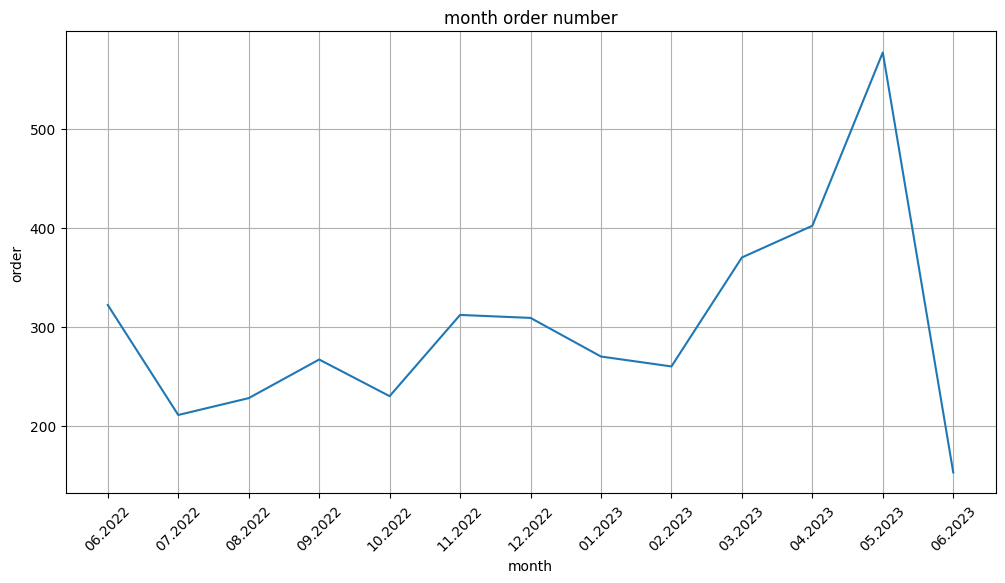

In [146]:
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('month')
ax.set_ylabel('order')
ax.set_title('month order number')
plt.xticks(
range(len(df_orders_monthly.index)),
    [x.strftime('%m.%Y') for x in df_orders_monthly.index],
    rotation=45
)
plt.show()

## Feature Engineering

In this section, we want to create RFM(Recency、Frequency、Monetary ) features for our dataset

R : The new progress represents the number of days since the user last spent.   
F : Consumption frequency, which represents whether the user uses the service frequently.  
M : Consumption amount, which represents the total amount of money consumed by the user in a period of time.

In [20]:
df_sales['TotalPrice'] = df_sales['Quantity'] * df_sales['UnitPrice']

In [21]:
df_user = pd.DataFrame(df_sales['CustomerID'].unique())
df_user.columns = ['CustomerID']
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)


In [22]:
df_user

,CustomerID
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


#### `R`

In [23]:
df_recent_buy = df_sales.groupby('CustomerID').InvoiceDate.max().reset_index()
df_recent_buy.columns = ['CustomerID','LatestDate']
df_recent_buy

,CustomerID,LatestDate
0,14681,2023-03-30 15:52:00
1,14682,2022-12-04 12:12:00
2,14684,2023-05-15 11:33:00
3,14687,2023-02-23 11:59:00
4,14688,2023-06-02 12:26:00
...,...,...
975,16015,2023-06-06 10:58:00
976,16016,2023-06-06 14:35:00
977,16017,2023-04-23 12:56:00
978,16018,2023-05-01 14:13:00


In [24]:
df_recent_buy['R'] = (df_recent_buy['LatestDate'].max() - df_recent_buy['LatestDate']).dt.days
df_recent_buy

,CustomerID,LatestDate,R
0,14681,2023-03-30 15:52:00,70
1,14682,2022-12-04 12:12:00,187
2,14684,2023-05-15 11:33:00,25
3,14687,2023-02-23 11:59:00,106
4,14688,2023-06-02 12:26:00,7
...,...,...,...
975,16015,2023-06-06 10:58:00,3
976,16016,2023-06-06 14:35:00,2
977,16017,2023-04-23 12:56:00,46
978,16018,2023-05-01 14:13:00,38


In [25]:
df_user = pd.merge(df_user,df_recent_buy[['CustomerID','R']],on='CustomerID')
df_user

,CustomerID,R
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7
...,...,...
975,16015,3
976,16016,2
977,16017,46
978,16018,38


#### `F`

In [26]:
#F
df_frequency = df_sales.groupby('CustomerID').InvoiceDate.count().reset_index()
df_frequency.columns = ['CustomerID','F']
df_user = pd.merge(df_user,df_frequency,on='CustomerID')
df_user

,CustomerID,R,F
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324
...,...,...,...
975,16015,3,181
976,16016,2,224
977,16017,46,32
978,16018,38,28


#### `M`

In [27]:
df_revenue = df_sales.groupby('CustomerID').TotalPrice.sum().reset_index()
df_revenue.columns = ['CustomerID','M']
df_user = pd.merge(df_user,df_revenue,on='CustomerID')
df_user

,CustomerID,R,F,M
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10
...,...,...,...,...
975,16015,3,181,704.55
976,16016,2,224,1465.51
977,16017,46,32,211.88
978,16018,38,28,408.90


` check the distribution of RMF`

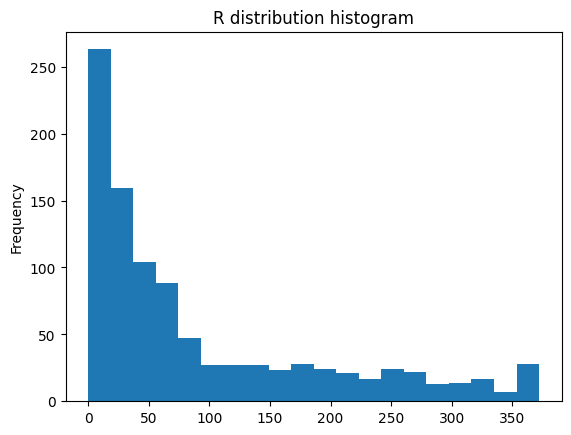

In [28]:
df_user['R'].plot(kind='hist',bins=20,title="R distribution histogram")
plt.show()

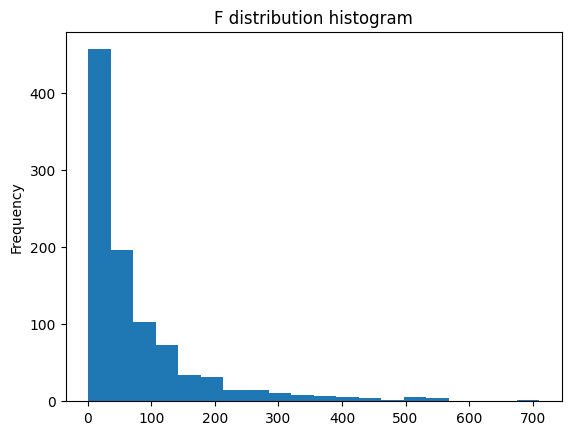

In [29]:
df_user.query('F < 800')['F'].plot(kind='hist',bins=20,title="F distribution histogram")
plt.show()

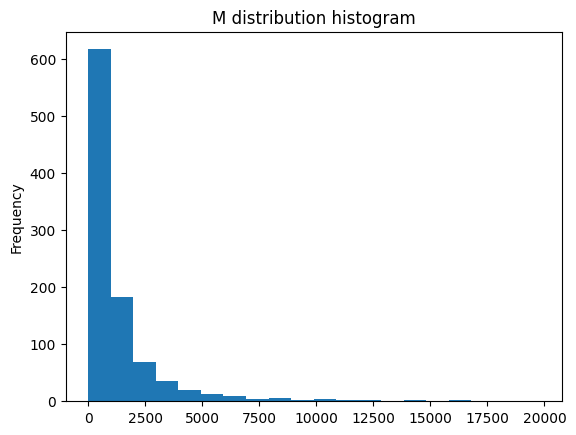

In [30]:
df_user.query('M < 20000')['M'].plot(kind='hist',bins=20,title="M distribution histogram")
plt.show()

## Model Building

#### Select the number of clusters

#1、How many groups would be optimal for division?

#2、what range of value should be considered for the first group,and what range of value should be considered for the second group?

In [31]:
from sklearn.cluster import KMeans

def show_elbow(df):
    k = range(1, 9)
    inertias = []

    for i in k:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df)
        inertias.append(kmeans.inertia_)

    # Plotting the elbow curve
    plt.figure(figsize=(8, 4))
    plt.plot(k, inertias, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

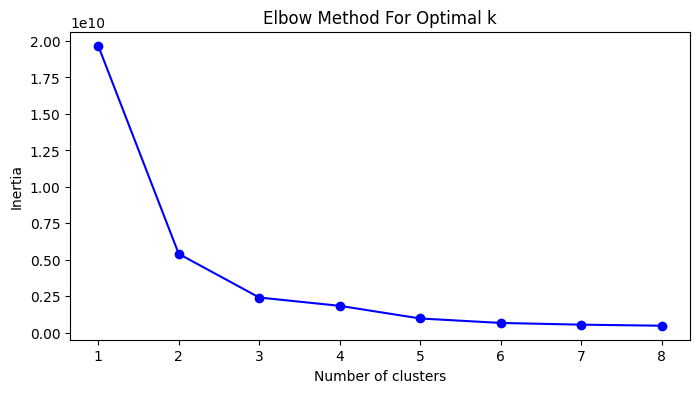

In [32]:

show_elbow(df_user)


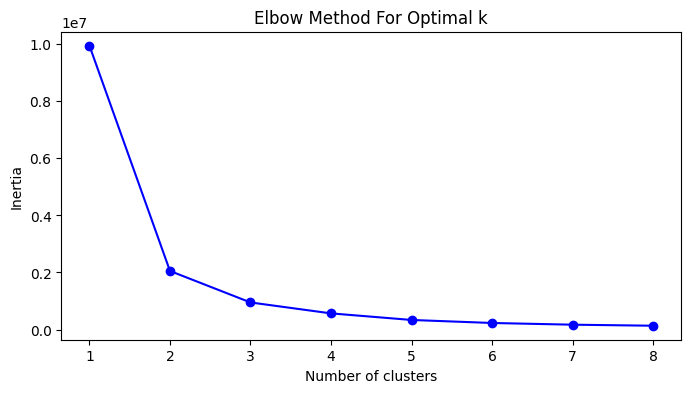

In [33]:
show_elbow(df_user[['R']])

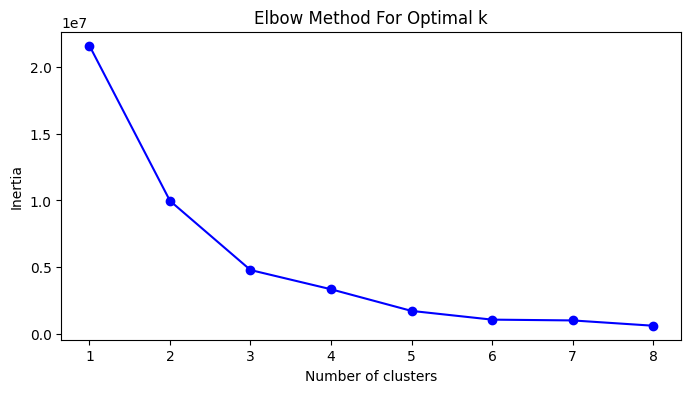

In [34]:
show_elbow(df_user[['F']])

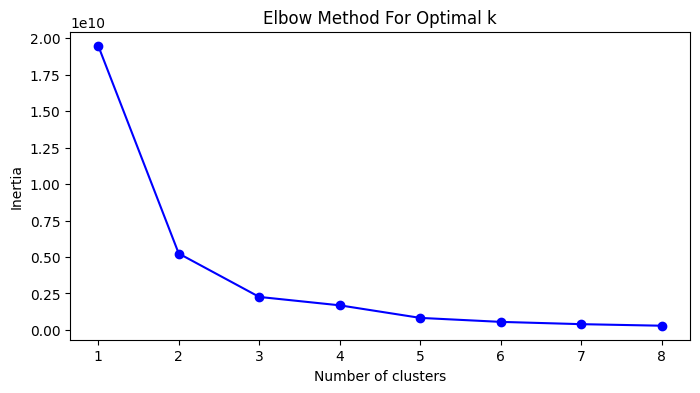

In [35]:
show_elbow(df_user[['M']])

#### Build k-mean for each parameters

In [36]:
kmeans_R = KMeans(n_clusters=3)
kmeans_F = KMeans(n_clusters=4)
kmeans_M = KMeans(n_clusters=4)

In [37]:
kmeans_R.fit(df_user[['R']])
kmeans_F.fit(df_user[['F']])
kmeans_M.fit(df_user[['M']])

KMeans(n_clusters=4)

In [38]:
df_user['R-valued'] = kmeans_R.predict(df_user[['R']])
df_user.head()

,CustomerID,R,F,M,R-valued
0,14681,70,7,498.95,0
1,14682,187,2,52.00,2
2,14684,25,390,1201.51,0
3,14687,106,15,628.38,2
4,14688,7,324,5579.10,0


In [39]:
df_user.groupby('R-valued')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
R-valued,,,,,,,,
0,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0
1,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
2,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0


In [52]:
# re-order the number of the cluster
def order_cluster(cluster_name,target_name,df,ascending=False):
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index()  
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_new = pd.merge(df,df_new[[cluster_name,'index']],on=cluster_name)
    df_new = df_new.drop([cluster_name],axis=1)
    df_new = df_new.rename(columns={'index':cluster_name})
    return df_new

In [53]:
df_user = order_cluster('R-valued','R',df_user,False)

In [55]:
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)
df_user.head()

,CustomerID,R,F,M,R-valued
0,14681,70,7,498.95,2
1,14682,187,2,52.00,1
2,14684,25,390,1201.51,2
3,14687,106,15,628.38,1
4,14688,7,324,5579.10,2


In [56]:
df_user.groupby('R-valued')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
R-valued,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [57]:
df_user['F-valued'] = kmeans_F.predict(df_user[['F']])
df_user.groupby('F-valued')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
F-valued,,,,,,,,
0,42.0,468.500000,141.746295,319.0,374.25,431.5,510.00,931.0
1,750.0,34.870667,26.845611,1.0,12.00,28.0,52.75,102.0
2,5.0,1429.800000,548.556469,1062.0,1112.00,1132.0,1477.00,2366.0
3,183.0,170.125683,56.429189,103.0,122.00,152.0,203.00,312.0


In [58]:
df_user = order_cluster('F-valued','F',df_user,True)
df_user.groupby('F-valued')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
F-valued,,,,,,,,
0,750.0,34.870667,26.845611,1.0,12.00,28.0,52.75,102.0
1,183.0,170.125683,56.429189,103.0,122.00,152.0,203.00,312.0
2,42.0,468.500000,141.746295,319.0,374.25,431.5,510.00,931.0
3,5.0,1429.800000,548.556469,1062.0,1112.00,1132.0,1477.00,2366.0


In [60]:
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)
df_user.head()

,CustomerID,R,F,M,R-valued,F-valued
0,14681,70,7,498.95,2,0
1,14682,187,2,52.00,1,0
2,14684,25,390,1201.51,2,2
3,14687,106,15,628.38,1,0
4,14688,7,324,5579.10,2,2


In [61]:
df_user['M-valued'] = kmeans_M.predict(df_user[['M']])
df_user = order_cluster('M-valued','M',df_user,True)
df_user.groupby('M-valued')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
M-valued,,,,,,,,
0,834.0,703.073574,578.357818,6.20,258.4075,496.325,1042.9275,2446.60
1,120.0,4177.986000,1576.482306,2463.05,2862.5850,3662.065,4971.8950,8347.20
2,19.0,12896.741053,3007.763001,9585.91,10450.9850,12393.700,14574.0600,19766.59
3,7.0,46663.441429,10484.139456,33643.08,38523.5500,44534.300,55393.4300,60632.75


In [62]:
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)
df_user.head()

,CustomerID,R,F,M,R-valued,F-valued,M-valued
0,14681,70,7,498.95,2,0,0
1,14682,187,2,52.00,1,0,0
2,14684,25,390,1201.51,2,2,0
3,14687,106,15,628.38,1,0,0
4,14688,7,324,5579.10,2,2,1


In [64]:
df_user['Total_RMF_Score'] = df_user['R-valued'] + df_user['F-valued'] +df_user['M-valued']
df_user

,CustomerID,R,F,M,R-valued,F-valued,M-valued,TotalScore,Total_RMF_Score
0,14681,70,7,498.95,2,0,0,2,2
1,14682,187,2,52.00,1,0,0,1,1
2,14684,25,390,1201.51,2,2,0,4,4
3,14687,106,15,628.38,1,0,0,1,1
4,14688,7,324,5579.10,2,2,1,5,5
...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,3
976,16016,2,224,1465.51,2,1,0,3,3
977,16017,46,32,211.88,2,0,0,2,2
978,16018,38,28,408.90,2,0,0,2,2


In [77]:
"""
0-2,LowValue
3-4,MediumValue
5-8,HighValue
"""

df_user.loc[(df_user['Total_RMF_Score']<=2) & (df_user['Total_RMF_Score']>=0),'Totalvalue'] = 'LowValue'
df_user.loc[(df_user['Total_RMF_Score']<=4) & (df_user['Total_RMF_Score']>=3),'Totalvalue'] = 'MediumValue'
df_user.loc[(df_user['Total_RMF_Score']<=8) & (df_user['Total_RMF_Score']>=5),'Totalvalue'] = 'HighValue'
df_user

,CustomerID,R,F,M,R-valued,F-valued,M-valued,TotalScore,Total_RMF_Score,Totalvalue,label
0,14681,70,7,498.95,2,0,0,2,2,LowValue,0
1,14682,187,2,52.00,1,0,0,1,1,LowValue,2
2,14684,25,390,1201.51,2,2,0,4,4,MediumValue,0
3,14687,106,15,628.38,1,0,0,1,1,LowValue,2
4,14688,7,324,5579.10,2,2,1,5,5,HighValue,0
...,...,...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,3,MediumValue,0
976,16016,2,224,1465.51,2,1,0,3,3,MediumValue,0
977,16017,46,32,211.88,2,0,0,2,2,LowValue,0
978,16018,38,28,408.90,2,0,0,2,2,LowValue,0


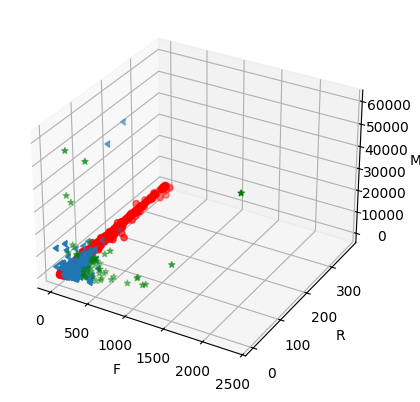

In [66]:
ax = plt.subplot(111,projection='3d')

ax.scatter(df_user.query("Totalvalue == 'HighValue'")['F'],
           df_user.query("Totalvalue == 'HighValue'")['R'],
           df_user.query("Totalvalue == 'HighValue'")['M'],
           c='g',marker='*'
          )
ax.scatter(df_user.query("Totalvalue == 'MediumValue'")['F'],
           df_user.query("Totalvalue == 'MediumValue'")['R'],
           df_user.query("Totalvalue == 'MediumValue'")['M'],
           marker=8
          )
ax.scatter(df_user.query("Totalvalue == 'LowValue'")['F'],
           df_user.query("Totalvalue == 'LowValue'")['R'],
           df_user.query("Totalvalue == 'LowValue'")['M'],
           c='r'
          )
ax.set_zlabel('M')
ax.set_ylabel('R')
ax.set_xlabel('F')
plt.show()

#### Build k-mean for the combination of RMF

In [119]:
train_x = df_user[["R","F","M"]]
train_x

,R,F,M
0,70,7,498.95
1,187,2,52.00
2,25,390,1201.51
3,106,15,628.38
4,7,324,5579.10
...,...,...,...
975,3,181,704.55
976,2,224,1465.51
977,46,32,211.88
978,38,28,408.90


In [120]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)


In [121]:
kmeans_RFM = KMeans(n_clusters=3)
kmeans_RFM.fit(train_x)

KMeans(n_clusters=3)

In [122]:
RFM_label = kmeans_RFM.predict(train_x)
df_user['label'] = RFM_label


In [127]:
df_user = order_cluster('label',['R','F','M'],df_user,False)
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)

In [131]:
df_user = order_cluster('label',['R','F','M'],df_user,False)
df_user = df_user.sort_values(by='CustomerID',ascending=True).reset_index(drop=True)

In [133]:
df_user

,CustomerID,R,F,M,R-valued,F-valued,M-valued,TotalScore,Total_RMF_Score,Totalvalue,label_raw,label
0,14681,70,7,498.95,2,0,0,2,2,LowValue,1,2
1,14682,187,2,52.00,1,0,0,1,1,LowValue,2,1
2,14684,25,390,1201.51,2,2,0,4,4,MediumValue,1,2
3,14687,106,15,628.38,1,0,0,1,1,LowValue,2,1
4,14688,7,324,5579.10,2,2,1,5,5,HighValue,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,2,1,0,3,3,MediumValue,1,2
976,16016,2,224,1465.51,2,1,0,3,3,MediumValue,1,2
977,16017,46,32,211.88,2,0,0,2,2,LowValue,1,2
978,16018,38,28,408.90,2,0,0,2,2,LowValue,1,2


In [134]:
df_user.groupby('Totalvalue')['label'].describe()

,count,mean,std,min,25%,50%,75%,max
Totalvalue,,,,,,,,
HighValue,52.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0
LowValue,740.0,1.393243,0.780831,0.0,1.0,2.0,2.0,2.0
MediumValue,188.0,1.973404,0.191630,0.0,2.0,2.0,2.0,2.0


## Visualization

In [147]:
import plotly.graph_objs as go 
import plotly.offline as py
trace1 = go.Scatter3d(
  x=df_user['R'],
  y=df_user['F'],
  z=df_user['M'],
  mode='markers',
   marker=dict(
    color=df_user['label'],
    size=10,
    line=dict(
      color=df_user['label'],
      width=12
    ),
    opacity=0.8
   )
)
df_3dfid = [trace1]

layout = go.Layout(
  margin=dict(
    l=20,
    r=0,
    b=20,
    t=0
  ),
  scene=dict(
      xaxis=dict(title='R'),
      yaxis=dict(title='F'),
      zaxis=dict(title='M')
    )
)

fig = go.Figure(data=df_3dfid, layout=layout)
py.offline.plot(fig)

'temp-plot.html'